In [ ]:
pip install pyomo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from random import randint
import numpy as np
import matplotlib.pyplot as plt

# $f^{CO2}$

In this section we define the $f^{CO2}$ function and we define a list of the capacity and CO2 emission for each production asset.

In [ ]:
def f_CO2(I, P, CO2, l):
    f = 0
    sum_P = 0
    for i in range(I - 1):
        # Update the running sum of capacities
        sum_P += P[i]
        # Calculate the term for this asset and add it to the result
        f += (CO2[i + 1] - CO2[i]) * max(0, l - sum_P)
    return f

In [ ]:
CO2 = [0, 0, 0, 484, 0, 429, 986, 777]
P = [25504, 13612, 19099, 2234, 61370, 12752, 1818, 2890]

# Data

In this section we put the data into format needed to apply the BRD algorithm. For the EV we use all of the data (arrival time, departure time, energy), for the non-flexible part of the load, we use "forecast-day-1" part of the data.

In [ ]:
file_path = '/content/ev_scenarios.csv'
dfEV = pd.read_csv(file_path, sep=';', decimal='.')
print(dfEV.head())

             day  ev_id  time_slot_arr  time_slot_dep  energy_need (kWh)
0     01/01/2019      1             36             14                5.0
1     01/01/2019      2             39             16                5.9
2     01/01/2019      3             37             15                5.0
3     01/01/2019      4             39             14                9.9
4     01/01/2019      5             35             16                5.0
...          ...    ...            ...            ...                ...
3645  31/12/2019      6             34             16               23.8
3646  31/12/2019      7             35             15                8.4
3647  31/12/2019      8             33             15               12.8
3648  31/12/2019      9             39             12               13.0
3649  31/12/2019     10             35             13                5.0

[3650 rows x 5 columns]


In [ ]:
file_path2 = '/content/eCO2mix_RTE_Annuel-Definitif_2019_summer.csv'
dfCO2 = pd.read_csv(file_path2, sep=';', decimal='.')

dfCO2['date'] = pd.to_datetime(dfCO2['date'], format="%Y-%m-%d %H:%M:%S")

print(dfCO2.head())

                 date  consumption  forecast_day-1  forecast_hour-1  fuel  \
0 2019-06-01 00:00:00      45727.0         45500.0          45900.0  86.0   
1 2019-06-01 00:30:00      43602.0         43100.0          43000.0  78.0   
2 2019-06-01 01:00:00      40816.0         40500.0          40700.0  78.0   
3 2019-06-01 01:30:00      40112.0         40900.0          40800.0  78.0   
4 2019-06-01 02:00:00      39285.0         40000.0          40100.0  79.0   

   coal     gas  nuclear   wind  solar  hydro_pumping  bioenergy  co2_rate  
0  18.0  2088.0  39794.0  541.0    0.0          -49.0     1125.0      21.0  
1  19.0  1979.0  39460.0  623.0    0.0         -396.0     1131.0      20.0  
2  18.0  1496.0  38100.0  690.0    0.0         -917.0     1134.0      18.0  
3  19.0   774.0  38353.0  769.0    0.0         -941.0     1126.0      13.0  
4  19.0   676.0  37938.0  846.0    0.0         -946.0     1133.0      13.0  


In [ ]:
EV = dfEV.groupby('day').apply(lambda x: [
    x['time_slot_arr'].tolist(),
    x['time_slot_dep'].tolist(),
    x['energy_need (kWh)'].tolist()
]).to_list()

In [ ]:
forecast = dfCO2.groupby(dfCO2['date'].dt.date)['forecast_day-1'].apply(list)
forecast = forecast.tolist()

# Water-filling method

We use water-filling method, it works because the $f^{CO2}$ function is increasing, therefore by increasing the load on the time-slots that have the minimal current total load we get the distribution that is the most likely to consume the least energy-hungry assets, hence minimizing the total cost.

(The total load $l^*$ is optimal if there exists $l_{WF}$ such that $l^*_{EV} > 0 \Rightarrow l^*(t) = l_{WF}$ or $l^*_{EV}(t)=7$)

In [ ]:
def water(L,m,a,g):
  eps=0.1

  k=0
  l=[0]*len(L)
  somme=0

  while somme < m:
    k=k+1

    #get minimal load unsaturated timeslot
    j=0
    for t in range(g):
      if l[t]<7 and (l[j]>=7 or L[t]+l[t]<L[j]+l[j]):
        j=t

    for t in range(a,48):
      if l[t]<7 and (l[j]>=7 or L[t]+l[t]<L[j]+l[j]):
        j=t


    #add epsilon
    c=min(7,l[j]+eps)
    somme+=c-l[j]
    l[j]=c

  return l

Every agent will put his vehicle to charge during a fixed time interval and wants a specific battery level by the end. So he will try to do so in a way that minimizes his carbon footprint, by cleverly splitting the charging schedule throughout the time interval. The purpose is to balance the individual charging loads of all vehicles throughout the charging time, so that low CO2 emitting sources remain mostly enough without having to burn fossil or nuclear to meet the demand.

# Best-Response-Dynamics

In this algorithm each agent turn by turn solve his optimization problem where the load of the other agents is chosen in the same way (we start with the first agent to the last, it is not simultaenous). We do this until the squared difference of the loads at consecutive iterations is small enough.

In [ ]:
def BRD(L,e,a,g):
  d=0.5
  nu=0.001
  K=10000
  n=len(e)
  T=len(L)
  l=[]
  for j in range(n):
    l.append([0]*len(L))

  somme=0
  k=0
  while k<=K:

    k=k+1
    ll=[]
    for j in range(n):
      ll.append(l[j])

    for j in range(n):
      print('Agent ',j)
      U=[ll[i] for i in range(n) if j!=i]
      V=np.array(L)
      for x in U:
        V+=np.array(x)
      print('Consommation des autres:',list(V))
      ll[j] = water(V,e[j]/d,a[j],g[j])
      print(e[j]/d)
      print('Comes at ', a[j],' and leaves at ',g[j])
      print('New policy :',ll[j])

    somme=sum([sum([ (ll[i][t]-l[i][t])**2 for t in range(T)]) for i in range(n)])

    if somme<=nu:
      print("finish with error "+str(somme))
      return ll

    l=list(ll)

In [ ]:
T=48

L=forecast[0]
e=EV[0][2]
a=EV[0][0]
g=EV[0][1]
n=len(e)

print('Consommation externe: ',L)
print('Besoins individuels: ',e)
print('Heures de depart: ',a)
print('Heures d arrivee: ',g)
l=BRD(L,e,a,g)

Consommation externe:  [45500.0, 43100.0, 40500.0, 40900.0, 40000.0, 38100.0, 36400.0, 35600.0, 34800.0, 34300.0, 34300.0, 34100.0, 34000.0, 34200.0, 35100.0, 36200.0, 37600.0, 39200.0, 40900.0, 42300.0, 43000.0, 43700.0, 44300.0, 44900.0, 45900.0, 46200.0, 47500.0, 45400.0, 44700.0, 44400.0, 43400.0, 42800.0, 42300.0, 41700.0, 41500.0, 41100.0, 42000.0, 42700.0, 43600.0, 43300.0, 42600.0, 42000.0, 41600.0, 41700.0, 42300.0, 43800.0, 46500.0, 46200.0]
Besoins individuels:  [5.0, 5.9, 5.0, 9.9, 5.0, 5.0, 9.2, 5.0, 11.7, 13.1]
Heures de depart:  [36, 39, 37, 39, 35, 36, 38, 36, 36, 35]
Heures d arrivee:  [14, 16, 15, 14, 16, 13, 16, 13, 15, 16]
Agent  0
Consommation des autres: [45500.0, 43100.0, 40500.0, 40900.0, 40000.0, 38100.0, 36400.0, 35600.0, 34800.0, 34300.0, 34300.0, 34100.0, 34000.0, 34200.0, 35100.0, 36200.0, 37600.0, 39200.0, 40900.0, 42300.0, 43000.0, 43700.0, 44300.0, 44900.0, 45900.0, 46200.0, 47500.0, 45400.0, 44700.0, 44400.0, 43400.0, 42800.0, 42300.0, 41700.0, 41500.0,

We can observe that this algorithm converge by the fact that the sum of squared differences goes lower than the treshhold. The convergence is expected given that BRD converges to a steady state Nash Equilibrium.

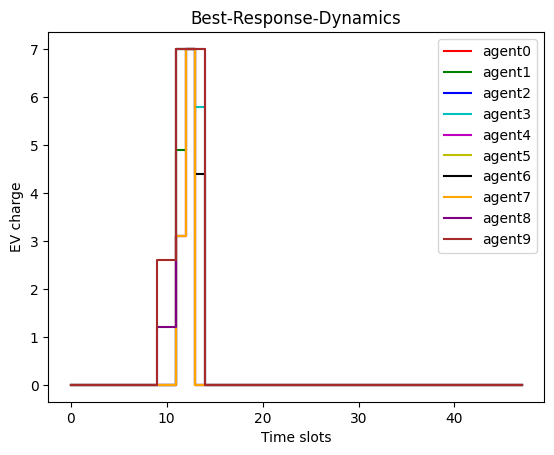

In [ ]:
x = range(48)
y =[]
u=range(n)
for i in u:
  y.append(l[i])
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
for i in range(len(u)):
  plt.plot(x, y[i], drawstyle='steps-post', color=colors[i], label='agent' + str(u[i]))
plt.legend()
plt.title('Best-Response-Dynamics')
plt.xlabel('Time slots')
plt.ylabel('EV charge')
plt.show()